In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics


In [2]:
df = pd.read_csv('../data/spam.csv', encoding='latin-1')
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df = df.rename(columns={"v1":"label", "v2":"text"})
df['label_num'] = df.label.map({'ham':0, 'spam':1})

In [3]:
df.head()

,label,text,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.text,
                                                    df.label_num, 
                                                    test_size = 0.33, 
                                                    random_state = 42)

In [5]:
count_vectorizer = CountVectorizer(stop_words='english',
                                   min_df=3, max_df=0.9)
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

In [6]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                                   min_df=0.05, max_df=0.9)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [7]:
tfidf_train.shape

(3733, 3)

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

accuracy:   0.979
Confusion matrix, without normalization


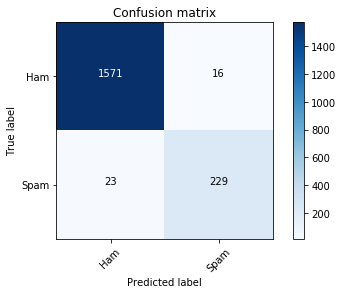

In [9]:
%matplotlib inline
count_nb = MultinomialNB()
count_nb.fit(count_train, y_train)
pred = count_nb.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Ham', 'Spam'])

accuracy:   0.863
Confusion matrix, without normalization


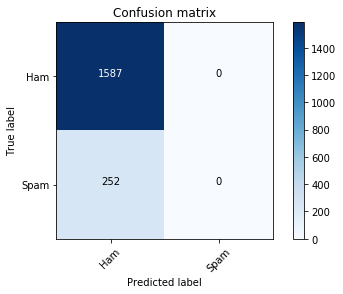

In [10]:
tfidf_svc = LinearSVC()
tfidf_svc.fit(tfidf_train, y_train)
pred = tfidf_svc.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Ham', 'Spam'])


In [11]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    See: https://stackoverflow.com/a/26980472
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    
    Modified by @kjam to support a dict return.
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    return {class_labels[0]: topn_class1,
            class_labels[1]: topn_class2
    }

In [12]:
most_informative_feature_for_binary_classification(count_vectorizer, count_nb, n=30)


{0: [(-8.997889450200717, '2morrow'),
  (-8.997889450200717, '3rd'),
  (-8.997889450200717, '4get'),
  (-8.997889450200717, '4th'),
  (-8.997889450200717, '530'),
  (-8.997889450200717, '5th'),
  (-8.997889450200717, '6th'),
  (-8.997889450200717, '7th'),
  (-8.997889450200717, '8th'),
  (-8.997889450200717, 'aah'),
  (-8.997889450200717, 'abi'),
  (-8.997889450200717, 'abiola'),
  (-8.997889450200717, 'able'),
  (-8.997889450200717, 'abt'),
  (-8.997889450200717, 'accept'),
  (-8.997889450200717, 'ache'),
  (-8.997889450200717, 'actually'),
  (-8.997889450200717, 'ad'),
  (-8.997889450200717, 'add'),
  (-8.997889450200717, 'adore'),
  (-8.997889450200717, 'advice'),
  (-8.997889450200717, 'aft'),
  (-8.997889450200717, 'afternoon'),
  (-8.997889450200717, 'ago'),
  (-8.997889450200717, 'ah'),
  (-8.997889450200717, 'aha'),
  (-8.997889450200717, 'ahead'),
  (-8.997889450200717, 'ahmad'),
  (-8.997889450200717, 'aight'),
  (-8.997889450200717, 'air')],
 1: [(-5.501381888734237, '16'),


In [13]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('vectorize', CountVectorizer(
                                    stop_words='english',
                                    min_df=3, max_df=0.9)),
                    ('mn_bayes', MultinomialNB())])

In [14]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vectorize', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.9, max_features=None, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('mn_bayes', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [15]:
sum(y_test == pipeline.predict(X_test)) / len(y_test)

0.9787928221859706

In [16]:
from sklearn.externals import joblib

In [17]:
joblib.dump(pipeline, '../data/bayes_spam_pipeline.pkl')

['../data/bayes_spam_pipeline.pkl']